In [1]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
from numpy.linalg import norm
from sklearn.cluster import KMeans

Iniciation K-Moyennes++

In [2]:
def initPlusPlus(X,K):
    N,p = np.shape(X)
    C = np.zeros((p,K))
    generator = np.random.default_rng()
    
    index = np.random.choice(N, 1,replace = False)
    liste_index = [index]
    C[:,0] = X[index,:]
    X = np.delete(X,index,0)
    #print("k=0 C[k]=",C[:,0],"index=",index)
    k=1
    
    while k < K:
        
        # calcul des distances
        NN = X.shape[0]
        dist = np.zeros(NN)
        for i in range(NN):
            # Para cada ponto em X, calcular a menor distância até qualquer centroide já escolhido
            dist[i] = np.min([np.linalg.norm(X[i, :] - C[:, j])**2 for j in range(k)])

        # calcul des probabilités
        dist_sum = np.sum(dist)
        if dist_sum == 0:
            dist_sum = 1  # Evitar divisão por zero caso todas as distâncias sejam muito pequenas
        probs = dist / dist_sum  # Probabilidade proporcional à distância
        
        # tirage aléatoire selon proba
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()  # Gerar um número aleatório para o sorteio
        index_next = np.where(cumulative_probs >= r)[0][0]  # Selecionar o próximo ponto
        
        C[:, k] = X[index_next, :]
        #print(f"k={k} C[k]={C[:, k]} index={index_next}")
        
        # Remover o ponto escolhido de X
        X = np.delete(X, index_next, 0)
        
        k += 1
        
    return C

Iniciation K-Medoids++

In [3]:
def initMedoidsPlusPlus(X, K):
    N, p = np.shape(X)
    C = np.zeros((K, p))  # Initialize C to store medoids as rows now (K, p)
    
    # Step 1: Randomly select the first medoid from the data points
    index = np.random.choice(N, 1, replace=False)
    C[0, :] = X[index, :].squeeze()  # Fix the shape mismatch by assigning correctly
    selected_indices = [index[0]]
    X_remaining = np.delete(X, index, 0)  # Remove the selected medoid from X

    k = 1
    while k < K:
        # Step 2: Calculate the minimum distance from each point in X_remaining to the already selected medoids
        NN = X_remaining.shape[0]
        dist = np.zeros(NN)
        for i in range(NN):
            dist[i] = np.min([np.linalg.norm(X_remaining[i, :] - C[j, :])**2 for j in range(k)])  # Use correct shape

        # Step 3: Calculate the probabilities proportional to the squared distances
        dist_sum = np.sum(dist)
        if dist_sum == 0:
            dist_sum = 1  # Avoid division by zero
        probs = dist / dist_sum

        # Step 4: Select the next medoid based on the computed probabilities
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()  # Generate a random number for probabilistic selection
        index_next = np.where(cumulative_probs >= r)[0][0]
        
        # Add the selected medoid to the C matrix
        C[k, :] = X_remaining[index_next, :].squeeze()  # Ensure correct shape for the medoid
        
        # Remove the selected point from X_remaining and update selected_indices
        selected_indices.append(index_next)
        X_remaining = np.delete(X_remaining, index_next, 0)
        
        k += 1

    return C

K-Moyennes

In [ ]:
def my_kmeans(X,K,init,Visualisation=False,Seuil=0.001,Max_iterations = 100):
    
    N,p = np.shape(X)
    iteration = 0        
    Dist=np.zeros((K,N))
    J=np.zeros(Max_iterations+1)
    J[0] = 10000000
    
    # Initialisation des clusters        
    Index_init = np.random.choice(N, K,replace = False)
    C = np.zeros((p,K))
    
    if init == "plusplus":
        C = initPlusPlus(X, K)
    else:
        for k in range(K):
            C[:,k] = X[Index_init[k],:].T 
        
    while iteration < Max_iterations:
        iteration +=1
        #################################################################
        # E step : estimation des données manquantes 
        
        for k in range(K):
            Dist[k, :] = np.linalg.norm(X - C[:, k].T, axis=1)
        
        # affectation des données aux clusters les plus proches
        y = np.argmin(Dist, axis=0)

        #################################################################
        # M Step : calcul des meilleurs centres      
        
        for k in range(K):
            C[:, k] = np.mean(X[y == k], axis=0)
            
        #################################################################
        # test du critère d'arrêt l'évolution du critère est inférieure 
        # au Seuil en pour ceent
        
        J[iteration] = np.sum([np.linalg.norm(X[y == k] - C[:, k].T)**2 for k in range(K)])/N
        # J[iteration] += np.sum(np.min(Dist[y,:],axis=0))/N # Critière variance intra totale
        
        # Vérifier si le changement dans J est inférieur au seuil
        if abs(J[iteration] - J[iteration - 1]) / J[iteration - 1] < Seuil:
            break
        
    return C, y, J[1:iteration]

K-Médoïdes

In [5]:
def my_kmedoides(X, K, init, Visualisation=False, Seuil=0.001, Max_iterations=100):
    N, p = np.shape(X)
    iteration = 0        
    Normes = np.zeros((K, N))

    J = np.zeros(Max_iterations+1)

    # Initialisation des clusters
    Index_init = np.random.choice(N, K, replace=False)
    C = np.zeros((K, p))

    if init == "plusplus":
        C = initMedoidsPlusPlus(X, K)  # Use the Medoids++ initialization
    else:
        for k in range(K):
            C[k, :] = X[Index_init[k], :]

    while iteration < Max_iterations:
        #################################################################
        # Affectation des données aux médoïdes les plus proches
        for k in range(K):
            # Calculer la distance de Manhattan entre chaque point et le médoïde k
            Normes[k, :] = np.sum(np.abs(X - C[k, :]), axis=1)  # Correct broadcasting for distance calculation
        
        # Affecter chaque point au médoïde le plus proche (avec la distance minimale)
        y = np.argmin(Normes, axis=0)  # Assigner chaque point au médoïde ayant la plus faible distance
        
        #################################################################
        # Calcul des meilleurs médoïdes
        for k in range(K):
            points_in_cluster = X[y == k]  # Points assignés au médoïde k
            
            if len(points_in_cluster) > 0:
                # Calculer la somme des distances pour chaque point dans le cluster
                distances = np.sum(np.abs(points_in_cluster[:, np.newaxis, :] - points_in_cluster[np.newaxis, :, :]), axis=2)
                
                # Trouver le point qui minimise la somme des distances dans le cluster
                medoid_index = np.argmin(np.sum(distances, axis=1))
                C[k, :] = points_in_cluster[medoid_index]  # Le nouveau médoïde est celui qui minimise les distances
            
        #################################################################
        # Test du critère d'arrêt
        J[iteration] = np.sum([np.linalg.norm(X[y == k] - C[k, :].T)**2 for k in range(K)])/N

        # Vérifier si le changement dans J est inférieur au seuil (critère de convergence)
        if iteration > 0 and abs(J[iteration] - J[iteration - 1]) / J[iteration - 1] < Seuil:
            break  # Arrêter si le critère est respecté
        
        iteration += 1  # Passer à l'itération suivante
            
    return C, y, J[:iteration+1]

K-Means ScikitLearn

In [6]:
def kmeans_sklearn(X, K, max_iter=100, tol=0.0001, random_state=None):
    # Initialize the KMeans model with the specified number of clusters and parameters
    kmeans = KMeans(n_clusters=K, max_iter=max_iter, tol=tol, random_state=random_state)
    
    # Fit the model to the data
    kmeans.fit(X)
    
    # Retrieve the centroids, labels, and inertia (sum of squared distances)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    
    return centroids, labels, inertia

Resultat Réel

C:\Users\ferna\AppData\Local\Temp\ipykernel_23056\4230861626.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[0:50, 0], X[0:50, 1], cmap=plt.cm.Set1,edgecolor='k',label=iris.target_names[0])
C:\Users\ferna\AppData\Local\Temp\ipykernel_23056\4230861626.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[50:100, 0], X[50:100, 1], cmap=plt.cm.Set1,edgecolor='k',label=iris.target_names[1])
C:\Users\ferna\AppData\Local\Temp\ipykernel_23056\4230861626.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[100:150, 0], X[100:150, 1], cmap=plt.cm.Set1,edgecolor='k',label=iris.target_names[2])


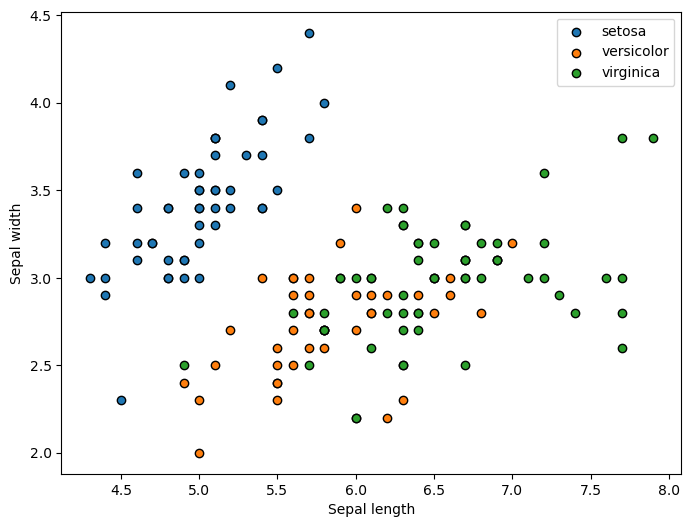

In [7]:
colors =['r','b','g','c','m','o']
n_colors = 6

#########################################################
#''' K means '''
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target
K = 3
N,p = np.shape(X)

fig = plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(X[0:50, 0], X[0:50, 1], cmap=plt.cm.Set1,edgecolor='k',label=iris.target_names[0])
plt.scatter(X[50:100, 0], X[50:100, 1], cmap=plt.cm.Set1,edgecolor='k',label=iris.target_names[1])
plt.scatter(X[100:150, 0], X[100:150, 1], cmap=plt.cm.Set1,edgecolor='k',label=iris.target_names[2])

plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.legend(scatterpoints=1)    

c:\Users\ferna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


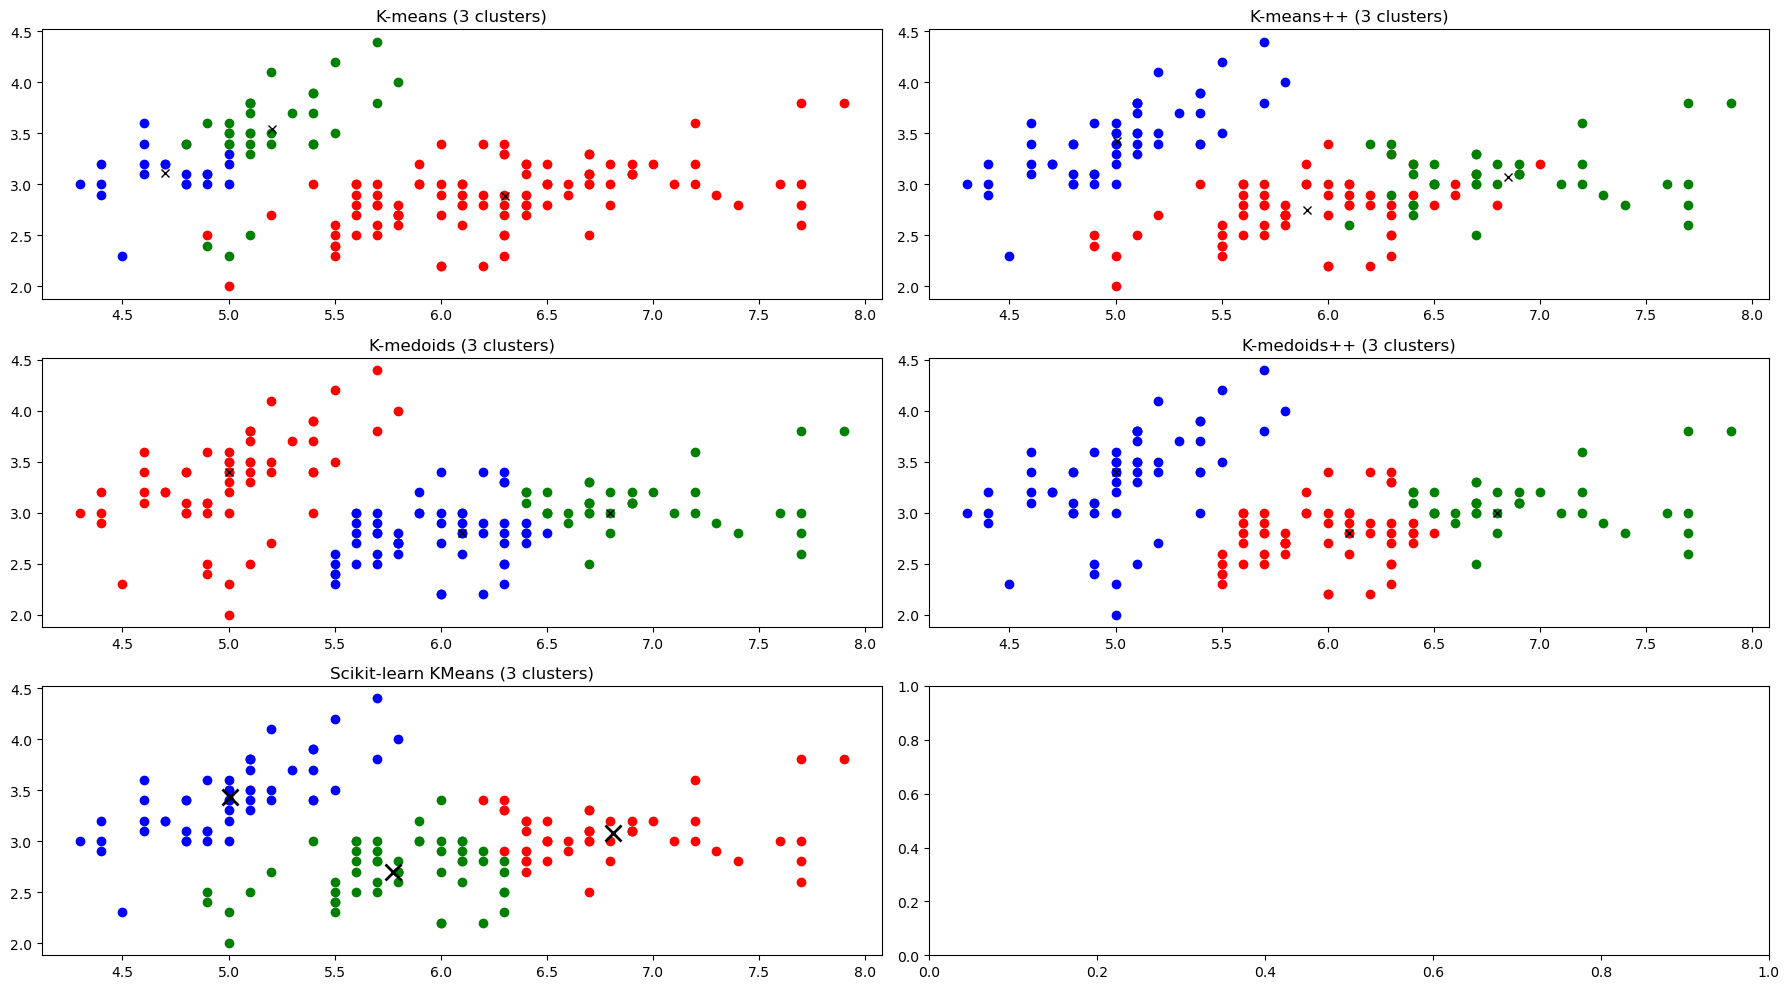

In [8]:
# Run k-means and k-medoids clustering
Cluster, y2, Critere = my_kmeans(iris.data, K, "", Visualisation=False)
ClusterPlus, yPlus, CriterePlus = my_kmeans(iris.data, K, "plusplus", Visualisation=False)
ClusterMedoid, yMedoid, CritereMedoid = my_kmedoides(X, K, "")
ClusterMedoidPlus, yMedoidPlus, CritereMedoidPlus = my_kmedoides(X, K, "plusplus")
ClusterSklearn, ySklearn, CritereSklearn = kmeans_sklearn(X, K)

# Create subplots for side-by-side comparison
fig, axs = plt.subplots(3, 2, figsize=(18, 10))

# Plot first graph (K-means)
for k in range(K):
    axs[0,0].plot(X[y2 == k, 0], X[y2 == k, 1], colors[k % len(colors)] + 'o')
axs[0,0].plot(Cluster[0, :], Cluster[1, :], 'kx')
axs[0,0].set_title(f'K-means ({K} clusters)')

# Plot second graph (K-means++ initialization)
for k in range(K):
    axs[0,1].plot(X[yPlus == k, 0], X[yPlus == k, 1], colors[k % len(colors)] + 'o')
axs[0,1].plot(ClusterPlus[0, :], ClusterPlus[1, :], 'kx')
axs[0,1].set_title(f'K-means++ ({K} clusters)')

# Plot third graph (K-medoids)
for k in range(K):
    axs[1,0].plot(X[yMedoid == k, 0], X[yMedoid == k, 1], colors[k % len(colors)] + 'o')
axs[1,0].plot(ClusterMedoid[:, 0], ClusterMedoid[:, 1], 'kx')
axs[1,0].set_title(f'K-medoids ({K} clusters)')

# Plot fourth graph (K-medoids)
for k in range(K):
    axs[1,1].plot(X[yMedoidPlus == k, 0], X[yMedoidPlus == k, 1], colors[k % len(colors)] + 'o')
axs[1,1].plot(ClusterMedoidPlus[:, 0], ClusterMedoidPlus[:, 1], 'kx')
axs[1,1].set_title(f'K-medoids++ ({K} clusters)')

# Plot Scikit-learn KMeans
for k in range(K):
    axs[2, 0].plot(X[ySklearn == k, 0], X[ySklearn == k, 1], colors[k % len(colors)] + 'o')
axs[2, 0].plot(ClusterSklearn[:, 0], ClusterSklearn[:, 1], 'kx', markersize=12, markeredgewidth=2)
axs[2, 0].set_title(f'Scikit-learn KMeans ({K} clusters)')

# Display the figure
plt.tight_layout()
plt.show()

##### Conclusions
Les trois algorithmes — K-means, K-means++ et K-medoids — produisent des résultats similaires aux clusters officiels et à l'implémentation scikit-learn. Cependant, K-means présente une variation significative lorsqu'il est exécuté plusieurs fois, en raison de sa forte dépendance à l'aléatoire pour l'initialisation des centroids. 

Ce problème est atténué dans K-means++, où l'initialisation est plus systématique, avec tous les points sauf le premier sélectionnés selon une règle probabiliste qui améliore la cohérence. K-medoids, quant à lui, montre des résultats stables, car il utilise des points réels du jeu de données comme centroids, offrant ainsi une meilleure cohérence et interprétabilité.

Il convient de noter que, dans la visualisation en 2D, certains points d’un cluster peuvent apparaître plus proches du centroid d’un autre cluster. Cela est dû à l'influence d'autres caractéristiques non représentées dans la projection en 2D, qui jouent un rôle important dans la classification.

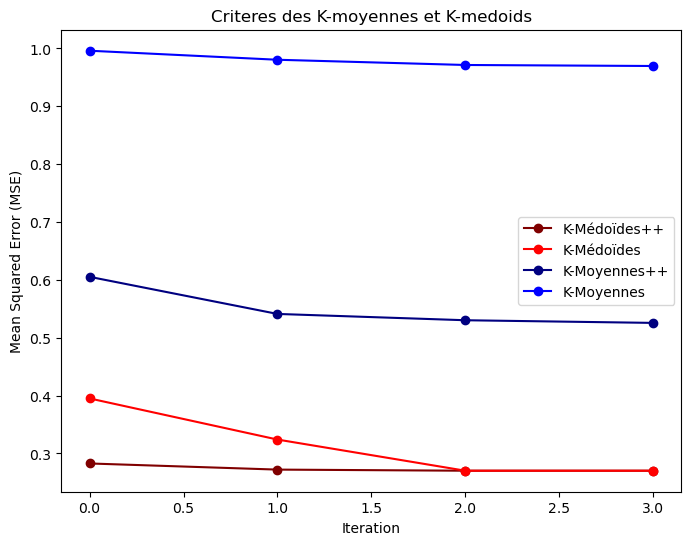

In [9]:
fig = plt.figure(figsize=(8, 6))
plt.plot(CritereMedoidPlus, 'o-', color='maroon')
plt.plot(CritereMedoid, 'o-', color='r')
plt.plot(CriterePlus, 'o-', color='navy')
plt.plot(Critere, 'o-', color='b')
plt.legend(['K-Médoïdes++', 'K-Médoïdes', 'K-Moyennes++', 'K-Moyennes'])
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Criteres des K-moyennes et K-medoids')
plt.show()

##### Conclusions
Bien que le nombre d'itérations varie en fonction des appels de fonction (en raison de l'initialisation aléatoire), K-means++ se révèle généralement plus efficace que le K-means classique, grâce à son initialisation plus stratégique. K-medoids, tout en affichant le MSE le plus bas dans l'ensemble, peut également être affecté par l'aléa de l'initialisation.

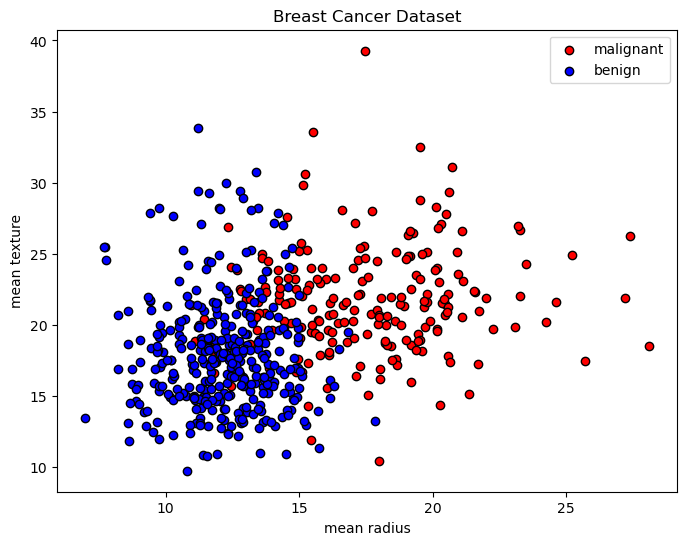

c:\Users\ferna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


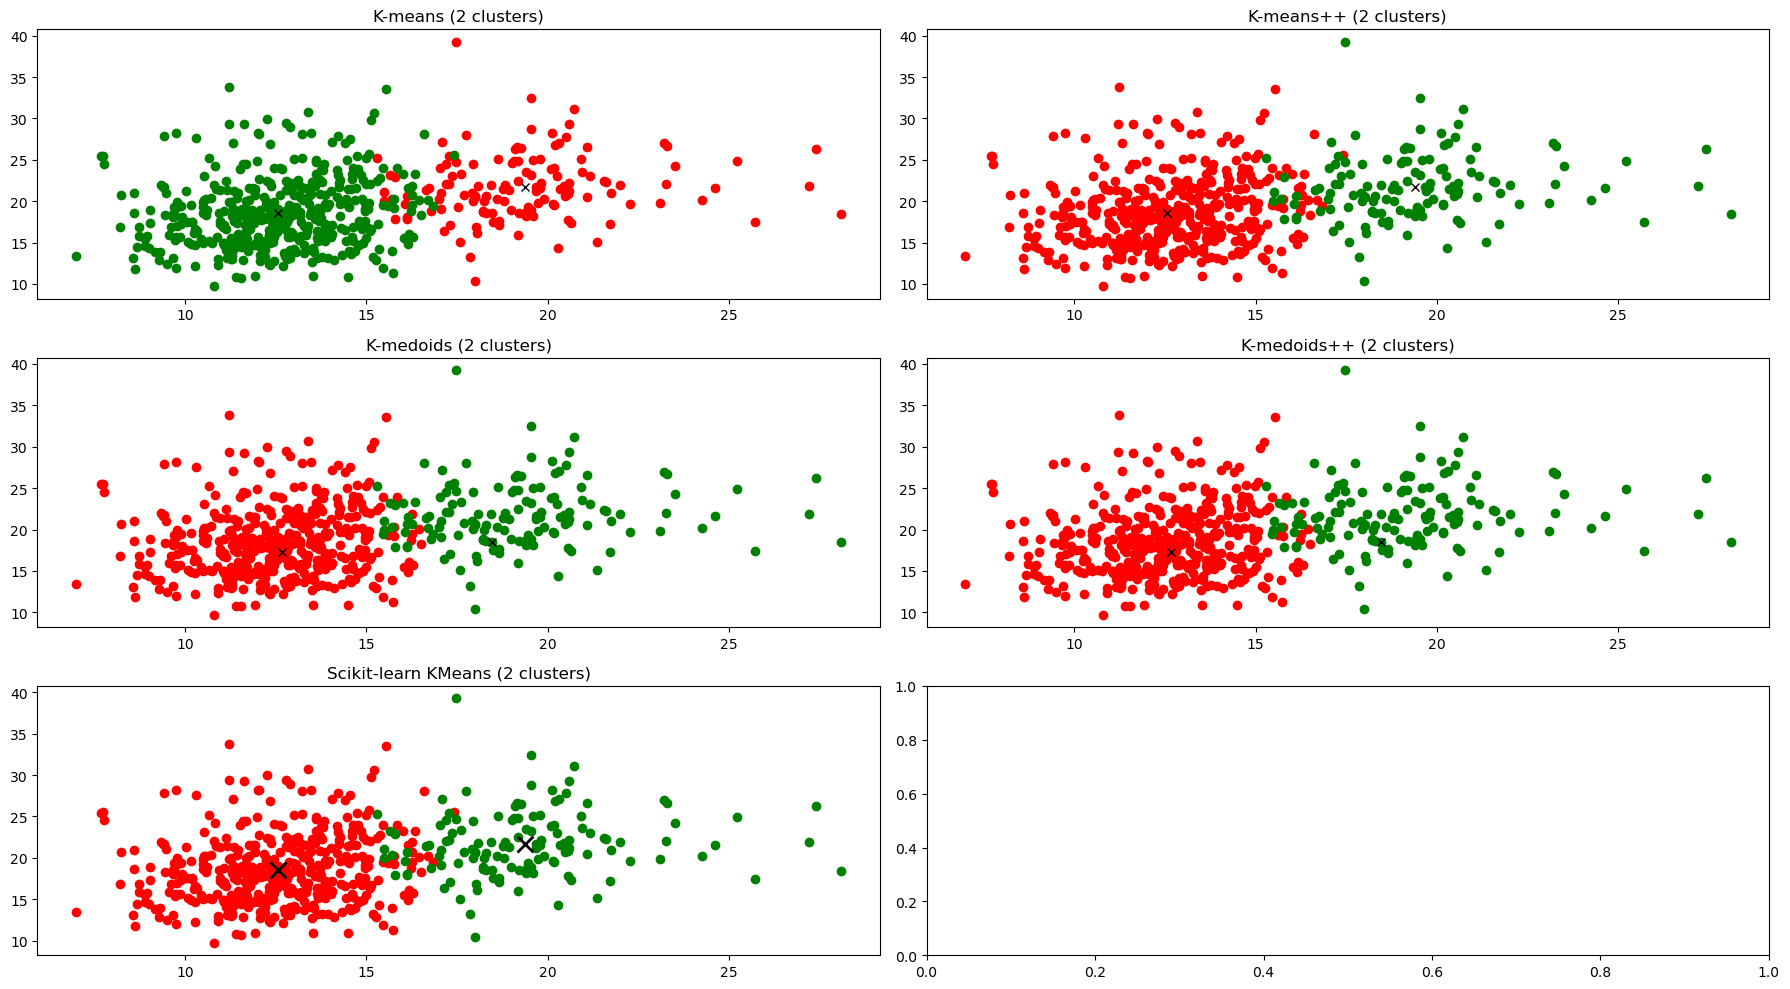

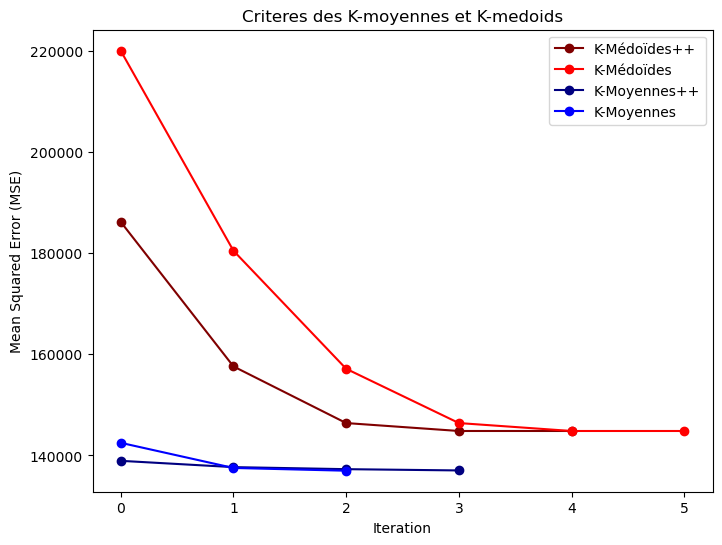

In [18]:
# Load the Breast Cancer dataset
breast_cancer = datasets.load_breast_cancer()
Xbreast = breast_cancer.data#[:, :2]  # We take the first two features for visualization purposes
ybreast = breast_cancer.target
Kbreast = 2  # Number of clusters
Nbreast, pbreast = np.shape(X)
colors = ['r', 'g', 'b', 'y', 'c', 'm']

# Plot the data (First two features)
fig = plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(Xbreast[ybreast == 0, 0], Xbreast[ybreast == 0, 1], color='r', edgecolor='k', label=breast_cancer.target_names[0])
plt.scatter(Xbreast[ybreast == 1, 0], Xbreast[ybreast == 1, 1], color='b', edgecolor='k', label=breast_cancer.target_names[1])
plt.xlabel(breast_cancer.feature_names[0])
plt.ylabel(breast_cancer.feature_names[1])
plt.legend(scatterpoints=1)
plt.title("Breast Cancer Dataset")
plt.show()

# Run k-means and k-medoids clustering
Cluster_b, y2_b, Critere_b = my_kmeans(breast_cancer.data, Kbreast, "", Visualisation=False)
ClusterPlus_b, yPlus_b, CriterePlus_b = my_kmeans(breast_cancer.data, Kbreast, "plusplus", Visualisation=False)
ClusterMedoid_b, yMedoid_b, CritereMedoid_b = my_kmedoides(Xbreast, Kbreast, "")
ClusterMedoidPlus_b, yMedoidPlus_b, CritereMedoidPlus_b = my_kmedoides(Xbreast, Kbreast, "plusplus")
ClusterSklearn_b, ySklearn_b, Inertia_b = kmeans_sklearn(Xbreast, Kbreast)

# Create subplots for side-by-side comparison
fig, axs = plt.subplots(3, 2, figsize=(18, 10))

# Plot first graph (K-means)
for k in range(Kbreast):
    axs[0,0].plot(Xbreast[y2_b == k, 0], Xbreast[y2_b == k, 1], colors[k % len(colors)] + 'o')
axs[0,0].plot(Cluster_b[0, :], Cluster_b[1, :], 'kx')
axs[0,0].set_title(f'K-means ({Kbreast} clusters)')

# Plot second graph (K-means++ initialization)
for k in range(Kbreast):
    axs[0,1].plot(Xbreast[yPlus_b == k, 0], Xbreast[yPlus_b == k, 1], colors[k % len(colors)] + 'o')
axs[0,1].plot(ClusterPlus_b[0, :], ClusterPlus_b[1, :], 'kx')
axs[0,1].set_title(f'K-means++ ({Kbreast} clusters)')

# Plot third graph (K-medoids)
for k in range(Kbreast):
    axs[1,0].plot(Xbreast[yMedoid_b == k, 0], Xbreast[yMedoid_b == k, 1], colors[k % len(colors)] + 'o')
axs[1,0].plot(ClusterMedoid_b[:, 0], ClusterMedoid_b[:, 1], 'kx')
axs[1,0].set_title(f'K-medoids ({Kbreast} clusters)')

# Plot fourth graph (K-medoids)
for k in range(Kbreast):
    axs[1,1].plot(Xbreast[yMedoidPlus_b == k, 0], Xbreast[yMedoidPlus_b == k, 1], colors[k % len(colors)] + 'o')
axs[1,1].plot(ClusterMedoidPlus_b[:, 0], ClusterMedoidPlus_b[:, 1], 'kx')
axs[1,1].set_title(f'K-medoids++ ({Kbreast} clusters)')

# Plot Scikit-learn KMeans
for k in range(Kbreast):
    axs[2, 0].plot(Xbreast[ySklearn_b == k, 0], Xbreast[ySklearn_b == k, 1], colors[k % len(colors)] + 'o')
axs[2, 0].plot(ClusterSklearn_b[:, 0], ClusterSklearn_b[:, 1], 'kx', markersize=12, markeredgewidth=2)
axs[2, 0].set_title(f'Scikit-learn KMeans ({Kbreast} clusters)')

# Display the figure
plt.tight_layout()
plt.show()

# Plot the criterion (MSE or within-cluster sum of squares) over iterations
fig = plt.figure(figsize=(8, 6))
plt.plot(CritereMedoidPlus_b, 'o-', color='maroon')
plt.plot(CritereMedoid_b, 'o-', color='r')
plt.plot(CriterePlus_b, 'o-', color='navy')
plt.plot(Critere_b, 'o-', color='b')
plt.legend(['K-Médoïdes++', 'K-Médoïdes', 'K-Moyennes++', 'K-Moyennes'])
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Criteres des K-moyennes et K-medoids')
plt.show()

##### Conclusions
Les résultats obtenus avec le jeu de données Breast Cancer sont cohérents avec ceux du jeu de données Iris, démontrant ainsi la robustesse et l’applicabilité de ces méthodes de classification pour différents ensembles de données.